In [ ]:
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 31.2 MB/s eta 0:00:00


In [ ]:
import sympy as sp

# Parâmetros do veículo
mass, wheel_radius, drag_coeff, frontal_area, rolling_resistance = sp.symbols(
    'mass, wheel_radius, drag_coeff, frontal_area, rolling_resistance'
)
road_grade, environment_density, g = sp.symbols('road_grade, environment_density, g')

# Parâmetros da transmissão
final_drive_ratio, transmission_efficiency = sp.symbols('final_drive_ratio, transmission_efficiency')

# Parâmetros do inversor
inverter_efficiency, Vdc = sp.symbols('inverter_efficiency, Vdc')

# Parâmetros do pneu
E_tire, Cy, Cx, Cz, c1, c2, tire_friction_coef = sp.symbols(
    'E_tire, Cy, Cx, Cz, c1, c2, tire_friction_coef'
)

# Parâmetros do motor
rs, ld, lq, lambda_m, p, jm, kf, torque_constant = sp.symbols(
    'rs, ld, lq, lambda_m, p, jm, kf, torque_constant'
)

# Tempo
t = sp.symbols('t')

# Variáveis de estado
vehicle_velocity = sp.Function('vehicle_velocity')(t)
vehicle_position = sp.Function('vehicle_position')(t)
wm = sp.Function('wm')(t)  # velocidade angular do motor
theta_m = sp.Function('theta_m')(t)  # posição angular do motor
isd = sp.Function('isd')(t)  # corrente d
isq = sp.Function('isq')(t)  # corrente q
iso = sp.Function('iso')(t)  # corrente zero

# Variáveis de entrada
pedal_position = sp.Function('pedal_position')(t)

# Vetor de estados
X = sp.Matrix([
    vehicle_velocity, vehicle_position, wm, theta_m,
    isd, isq, iso
])

# Forças de resistência
half_rho = 0.5 * environment_density
v2 = vehicle_velocity**2
aerodynamic_force = half_rho * drag_coeff * frontal_area * v2
rolling_force = rolling_resistance * mass * g * sp.cos(road_grade)
grade_force = mass * g * sp.sin(road_grade)
resistance_force = aerodynamic_force + rolling_force + grade_force

# Torque de carga
wheel_torque_resistance = resistance_force * wheel_radius
load_torque = wheel_torque_resistance / (final_drive_ratio * transmission_efficiency)

# Transformações da transmissão
wheel_speed = wm / final_drive_ratio
wheel_torque_motor = torque_constant * isq * final_drive_ratio * transmission_efficiency

# Modelo do pneu
Fz = mass * g  # força vertical
vel_ang_roda = wm / final_drive_ratio
slip_ratio = (vel_ang_roda * wheel_radius - vehicle_velocity) / sp.Max(vehicle_velocity, 0.1)

# Força longitudinal do pneu (Pacejka simplificado)
Cs = c1 * sp.sin(2 * sp.atan(Fz / c2))
D = tire_friction_coef * Fz
Bx = Cs / (Cx * D) if (Cx * D) != 0 else 0
arg_arctan = Bx * slip_ratio
tire_longitudinal_force = D * sp.sin(
    Cx * sp.atan(arg_arctan - E_tire * (arg_arctan - sp.atan(arg_arctan)))
)

# Limitação da força de tração
traction_force_ideal = wheel_torque_motor / wheel_radius
traction_force_limited = sp.Min(traction_force_ideal, tire_longitudinal_force)

# Dinâmica do veículo
vehicle_acceleration = (traction_force_limited - resistance_force) / mass

# Dinâmica elétrica do motor
we = p * wm  # velocidade elétrica

# Tensões do inversor (simplificado)
vd = sp.Function('vd')(t)  # tensão d
vq = sp.Function('vq')(t)  # tensão q

# Equações do motor
d_isd = (vd - rs * isd + we * lq * isq) / ld
d_isq = (vq - rs * isq - we * (ld * isd + lambda_m)) / lq
d_iso = -rs * iso / (0.1 * (ld + lq) / 2)  # simplificado

# Dinâmica mecânica do motor
ce = torque_constant * isq  # torque elétrico
d_wm = (ce - load_torque - kf * wm) / jm
d_theta_m = wm


# Sistema de EDOs completo
sis_edos = sp.Matrix([
    vehicle_acceleration,                    # d(vehicle_velocity)/dt
    vehicle_velocity,                       # d(vehicle_position)/dt
    d_wm,                                   # d(wm)/dt
    d_theta_m,                             # d(theta_m)/dt
    d_isd,                                  # d(isd)/dt
    d_isq,                                  # d(isq)/dt
    d_iso                                   # d(iso)/dt
])

print("Sistema de EDOs da Dinâmica Veicular:")
print(sis_edos)

# Entradas do sistema
U = sp.Matrix([pedal_position, vd, vq])

print("\nVariáveis de estado:")
print(X)
print("\nEntradas:")
print(U)

Sistema de EDOs da Dinâmica Veicular:
Matrix([[(-0.5*drag_coeff*environment_density*frontal_area*vehicle_velocity(t)**2 - g*mass*rolling_resistance*cos(road_grade) - g*mass*sin(road_grade) + Min(-g*mass*tire_friction_coef*sin(Cx*atan(E_tire*(-atan(c1*(-vehicle_velocity(t) + wheel_radius*wm(t)/final_drive_ratio)*sin(2*atan(g*mass/c2))/(Cx*g*mass*tire_friction_coef*Max(0.1, vehicle_velocity(t)))) + c1*(-vehicle_velocity(t) + wheel_radius*wm(t)/final_drive_ratio)*sin(2*atan(g*mass/c2))/(Cx*g*mass*tire_friction_coef*Max(0.1, vehicle_velocity(t)))) - c1*(-vehicle_velocity(t) + wheel_radius*wm(t)/final_drive_ratio)*sin(2*atan(g*mass/c2))/(Cx*g*mass*tire_friction_coef*Max(0.1, vehicle_velocity(t))))), final_drive_ratio*torque_constant*transmission_efficiency*isq(t)/wheel_radius))/mass], [vehicle_velocity(t)], [(-kf*wm(t) + torque_constant*isq(t) - wheel_radius*(0.5*drag_coeff*environment_density*frontal_area*vehicle_velocity(t)**2 + g*mass*rolling_resistance*cos(road_grade) + g*mass*sin(road_

In [ ]:
#@title Linearização do Sistema de Dinâmica Veicular

# Pontos de equilíbrio (steady-state) para todas as variáveis de estado
v_ss, pos_ss, wm_ss, theta_m_ss = sp.symbols('v_ss, pos_ss, wm_ss, theta_m_ss')
isd_ss, isq_ss, iso_ss = sp.symbols('isd_ss, isq_ss, iso_ss')

# Pontos de equilíbrio para as entradas
pedal_ss, vd_ss, vq_ss = sp.symbols(
    'pedal_ss, vd_ss, vq_ss'
)

# Jacobiana dos estados (Matriz A)
A = sis_edos.jacobian(X).subs([
    (vehicle_velocity, v_ss),
    (vehicle_position, pos_ss),
    (wm, wm_ss),
    (theta_m, theta_m_ss),
    (isd, isd_ss),
    (isq, isq_ss),
    (iso, iso_ss),
    (pedal_position, pedal_ss),
    (vd, vd_ss),
    (vq, vq_ss)
])

# Jacobiana das entradas (Matriz B)
B = sis_edos.jacobian(U).subs([
    (vehicle_velocity, v_ss),
    (vehicle_position, pos_ss),
    (wm, wm_ss),
    (theta_m, theta_m_ss),
    (isd, isd_ss),
    (isq, isq_ss),
    (iso, iso_ss),
    (pedal_position, pedal_ss),
    (vd, vd_ss),
    (vq, vq_ss)
])

print("Matriz A (Jacobiana dos Estados):")
print("A =")
sp.pprint(A, use_unicode=True)
print("\n" + "="*80 + "\n")

print("Matriz B (Jacobiana das Entradas):")
print("B =")
sp.pprint(B, use_unicode=True)
print("\n" + "="*80 + "\n")

# Também podemos definir as matrizes C e D para completar a representação de espaço de estados
# Matriz C (saída) - assumindo que medimos todas as variáveis de estado
C = sp.eye(len(X))
print("Matriz C (Saída):")
print("C = I (matriz identidade)")
print("\n" + "="*80 + "\n")

# Matriz D (feedforward) - assumindo nenhum termo direto
D = sp.zeros(len(X), len(U))
print("Matriz D (Feedforward):")
print("D = 0 (matriz nula)")

Matriz A (Jacobiana dos Estados):
A =
⎡                               ⎛      ⎛       ⎛       wheel_radius⋅wmₛₛ⎞    ⎛ ↪
⎢                               ⎜      ⎜    c₁⋅⎜-vₛₛ + ─────────────────⎟⋅sin⎜ ↪
⎢                               ⎜      ⎜       ⎝       final_drive_ratio⎠    ⎝ ↪
⎢                               ⎜      ⎜  - ────────────────────────────────── ↪
⎢                               ⎜      ⎜                                       ↪
⎢                               ⎜      ⎜             Cx⋅g⋅mass⋅tire_friction_c ↪
⎢  Cx⋅g⋅mass⋅tire_friction_coef⋅⎜Eₜᵢᵣₑ⋅⎜- ──────────────────────────────────── ↪
⎢                               ⎜      ⎜                                       ↪
⎢                               ⎜      ⎜                                   2 ⎛ ↪
⎢                               ⎜      ⎜                                 c₁ ⋅⎜ ↪
⎢                               ⎜      ⎜                                     ⎝ ↪
⎢                               ⎜      ⎜                             1 

In [ ]:
#@title Expansão dos Termos da Matriz A

print("Elementos não nulos da Matriz A:")
print("A[0,0] =", A[0,0])  # di_sd/di_sd
print("A[0,2] =", A[0,2])  # di_sd/di_sq
print("A[0,5] =", A[0,5])  # di_sd/domega_m

print("\nA[1,0] =", A[1,1])  # di_sq/di_sd
print("A[1,1] =", A[2,0])  # di_sq/di_sq
print("A[1,3] =", A[1,3])  # di_sq/domega_m

print("\nA[3,1] =", A[3,1])  # domega_m/di_sq (torque)
print("A[3,3] =", A[3,3])  # domega_m/domega_m (atrito)
print("A[3,5] =", A[3,5])  # domega_m/dv_vehicle (carga veicular)

print("\nA[5,1] =", A[5,1])  # dv_vehicle/di_sq (força de tração)
print("A[5,5] =", A[5,5])  # dv_vehicle/dv_vehicle (resistência aerodinâmica)

Elementos não nulos da Matriz A:
A[0,0] = (-Cx*g*mass*tire_friction_coef*(E_tire*(-(-c1*(-v_ss + wheel_radius*wm_ss/final_drive_ratio)*sin(2*atan(g*mass/c2))*Heaviside(v_ss - 0.1)/(Cx*g*mass*tire_friction_coef*Max(0.1, v_ss)**2) - c1*sin(2*atan(g*mass/c2))/(Cx*g*mass*tire_friction_coef*Max(0.1, v_ss)))/(1 + c1**2*(-v_ss + wheel_radius*wm_ss/final_drive_ratio)**2*sin(2*atan(g*mass/c2))**2/(Cx**2*g**2*mass**2*tire_friction_coef**2*Max(0.1, v_ss)**2)) - c1*(-v_ss + wheel_radius*wm_ss/final_drive_ratio)*sin(2*atan(g*mass/c2))*Heaviside(v_ss - 0.1)/(Cx*g*mass*tire_friction_coef*Max(0.1, v_ss)**2) - c1*sin(2*atan(g*mass/c2))/(Cx*g*mass*tire_friction_coef*Max(0.1, v_ss))) + c1*(-v_ss + wheel_radius*wm_ss/final_drive_ratio)*sin(2*atan(g*mass/c2))*Heaviside(v_ss - 0.1)/(Cx*g*mass*tire_friction_coef*Max(0.1, v_ss)**2) + c1*sin(2*atan(g*mass/c2))/(Cx*g*mass*tire_friction_coef*Max(0.1, v_ss)))*cos(Cx*atan(E_tire*(-atan(c1*(-v_ss + wheel_radius*wm_ss/final_drive_ratio)*sin(2*atan(g*mass/c2))/(Cx*g*

In [ ]:
#@title Linearização em Ponto de Operação Específico

# Definir um ponto de operação típico
operating_point = {
    v_ss: 30.0,           # 20 m/s (72 km/h)
    pos_ss: 0.0,          # posição inicial
    wm_ss: 471.0,         # 100 rad/s do motor
    theta_m_ss: 0.0,      # posição angular zero
    isd_ss: 0.0,          # corrente d zero (controle por campo orientado)
    isq_ss: 20.0,         # corrente q para torque
    iso_ss: 0.0,          # corrente zero

    # Entradas no ponto de operação
    pedal_ss: 1,        # 50% do pedal
    vd_ss: 0.0,           # tensão d
    vq_ss: 480.0          # tensão q
}

# Substituir valores numéricos para os parâmetros típicos
param_values = {
    mass: 230,           # kg
    wheel_radius: 0.275,    # m
    drag_coeff: 0.3,
    frontal_area: 0.68,    # m²
    rolling_resistance: 0.015,
    road_grade: 0.0,      # radianos
    environment_density: 1.225,  # kg/m³
    g: 9.81,

    # Transmissão
    final_drive_ratio: 4.0,
    transmission_efficiency: 0.95,

    # Motor
    rs: 0.0732,              # Ω
    ld: 0.00078,            # H
    lq: 0.00078,            # H
    lambda_m: 0.04748,        # Wb
    p: 10,                 # pares de polos
    jm: 0.05769,              # kg·m²
    kf: 0.1,             # N·m·s/rad
    torque_constant: 0.71, # N·m/A

    # Pneu
    E_tire: 0.333,
    Cy: 1.627,
    Cx: 1.0,
    Cz: 4.396,
    c1: 931,
    c2: 366,
    tire_friction_coef: 1.45,

}


# Aplicar todas as substituições
A_num = A.subs(operating_point).subs(param_values)
B_num = B.subs(operating_point).subs(param_values)

print("Matriz A Numérica (no ponto de operação):")
print("A_num =")
sp.pprint(A_num, use_unicode=True)
print("\n" + "="*80 + "\n")

print("Matriz B Numérica (no ponto de operação):")
print("B_num =")
sp.pprint(B_num, use_unicode=True)

# Calcular autovalores para análise de estabilidade
print("\n" + "="*80 + "\n")
print("Análise de Estabilidade:")
try:
    eigenvalues = A_num.eigenvals()
    print("Autovalores da matriz A:")
    for eig, mult in eigenvalues.items():
        print(f"  λ = {eig} (multiplicidade: {mult})")

    # Verificar estabilidade
    stable = all(sp.re(eig) < 0 for eig in eigenvalues.keys())
    stability_msg = "ESTÁVEL" if stable else "INSTÁVEL"
    print(f"\nSistema: {stability_msg}")

except Exception as e:
    print(f"Erro no cálculo de autovalores: {e}")

Matriz A Numérica (no ponto de operação):
A_num =
⎡-0.0786283913956051  0  0.0029320216064772  0          0                  0   ↪
⎢                                                                              ↪
⎢         1           0          0           0          0                  0   ↪
⎢                                                                              ↪
⎢ -9.40450775925774   0  -1.73340266944011   0          0          12.30715895 ↪
⎢                                                                              ↪
⎢         0           0          1           0          0                  0   ↪
⎢                                                                              ↪
⎢         0           0        200.0         0  -93.8461538461538       4710.0 ↪
⎢                                                                              ↪
⎢         0           0  -608.717948717949   0       -4710.0       -93.8461538 ↪
⎢                                                          

Matriz C para velocidade do veículo:
Matrix([[1, 0, 0, 0, 0, 0, 0]])

Matriz D: Matrix([[0, 0, 0]])
FUNÇÕES DE TRANSFERÊNCIA PRINCIPAIS

1. FT: Velocidade do veículo → Tensão Vq
G_vel_Vq(s) = (-217897.01486327*s - 204487967.794761)/(1.0*s**5 + 1127.96587721468*s**4 + 22378581.4905959*s**3 + 20887050894.1655*s**2 + 49284398895.3478*s + 4320276293.49265)

2. FT: Velocidade do motor → Tensão Vq
G_omega_Vq(s) = (-74316305.9855727*s**2 - 69748838219.5931*s - 5483779496.01013)/(1.0*s**5 + 1127.96587721468*s**4 + 22378581.4905959*s**3 + 20887050894.1655*s**2 + 49284398895.3478*s + 4320276293.49265)

3. FT: Corrente Iq → Tensão Vq
G_iq_Vq(s) = (-6038461.53846154*s**3 - 5677805785.1928*s**2 - 10269522929.9288*s - 928622661.040443)/(1.0*s**5 + 1127.96587721468*s**4 + 22378581.4905959*s**3 + 20887050894.1655*s**2 + 49284398895.3478*s + 4320276293.49265)
CONVERSÃO PARA FORMA NUMÉRICA

G_vel_Vq(s) numérico:
Numerador: [-217897.01486327004, -204487967.7947611]
Denominador: [1.0, 1127.9658772146818, 

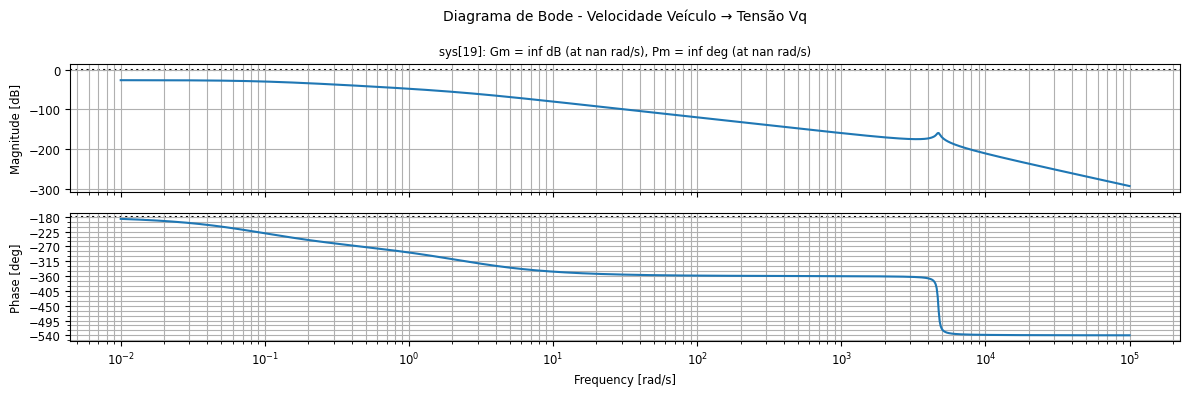

MATRIZ DE FUNÇÕES DE TRANSFERÊNCIA MIMO
Matriz de Funções de Transferência 2x2 criada com sucesso!

G[1,2] - Corrente Iq (isq) → Tensão Vq:
<TransferFunction>: sys[27]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     1282 s^4 + 1.326e+06 s^3 + 1.153e+08 s^2 + 2.048e+08 s + 1.85e+07
  -----------------------------------------------------------------------
  s^5 + 1128 s^4 + 2.238e+07 s^3 + 2.089e+10 s^2 + 4.928e+10 s + 4.32e+09


In [ ]:
import numpy as np
from scipy import signal
import control as ctrl

#@title Conversão para Funções de Transferência

# Definir variável de Laplace
s = sp.symbols('s')

def estados_para_tf_simbolico(A, B, C, D, saida_idx, entrada_idx):
    """
    Converte sistema de espaço de estados para função de transferência simbólica

    Args:
        A, B, C, D: Matrizes do espaço de estados
        saida_idx: Índice da saída desejada
        entrada_idx: Índice da entrada desejada

    Returns:
        Função de transferência simbólica
    """
    n = A.shape[0]

    # Matriz identidade
    I = sp.eye(n)

    # Matriz (sI - A)
    sIA = s * I - A

    # Inversa de (sI - A)
    try:
        sIA_inv = sIA.inv()
    except:
        # Se não for invertível, usar adjunta/determinante
        det_sIA = sIA.det()
        adj_sIA = sIA.adjugate()
        sIA_inv = adj_sIA / det_sIA

    # Função de transferência G(s) = C(sI - A)^-1 B + D
    G_s = (C[saida_idx, :] * sIA_inv * B[:, entrada_idx])[0,0] + D[saida_idx, entrada_idx]

    return sp.simplify(G_s)

def criar_matrizes_saida(n_estados, saidas_selecionadas):
    """
    Cria matriz C baseada nas saídas selecionadas
    """
    n_saidas = len(saidas_selecionadas)
    C = sp.zeros(n_saidas, n_estados)

    for i, saida_idx in enumerate(saidas_selecionadas):
        C[i, saida_idx] = 1

    return C

#@title Definir Matrizes C e D para diferentes saídas

# Número de estados
n_estados = A_num.shape[0]

# Caso 1: Velocidade do veículo como saída (índice 6)
saidas_velocidade = [0]  # v_vehicle
C_vel = criar_matrizes_saida(n_estados, saidas_velocidade)
D_vel = sp.zeros(1, U.shape[0])

# Caso 2: Velocidade do motor e velocidade do veículo
saidas_velocidades = [2, 0]  # omega_m, v_vehicle
C_vels = criar_matrizes_saida(n_estados, saidas_velocidades)
D_vels = sp.zeros(2, U.shape[0])

# Caso 3: Todas as variáveis de estado
C_full = sp.eye(n_estados)
D_full = sp.zeros(n_estados, U.shape[0])

print("Matriz C para velocidade do veículo:")
print(C_vel)
print("\nMatriz D:", D_vel)

#@title Calcular Funções de Transferência Principais

print("FUNÇÕES DE TRANSFERÊNCIA PRINCIPAIS")
print("="*50)

# 1. Velocidade do veículo em relação à tensão Vq
print("\n1. FT: Velocidade do veículo → Tensão Vq")
G_vel_Vq = estados_para_tf_simbolico(A_num, B_num, C_vel, D_vel, 0, 1)
print(f"G_vel_Vq(s) = {G_vel_Vq}")

# 2. Velocidade do motor em relação à tensão Vq
print("\n2. FT: Velocidade do motor → Tensão Vq")
C_omega = criar_matrizes_saida(n_estados, [2])  # omega_m
D_omega = sp.zeros(1, U.shape[0])
G_omega_Vq = estados_para_tf_simbolico(A_num, B_num, C_omega, D_omega, 0, 1)
print(f"G_omega_Vq(s) = {G_omega_Vq}")

# 3. Corrente Iq em relação à tensão Vq
print("\n3. FT: Corrente Iq → Tensão Vq")
C_iq = criar_matrizes_saida(n_estados, [5])  # i_sq (index 5 for isq(t))
D_iq = sp.zeros(1, U.shape[0])
G_iq_Vq = estados_para_tf_simbolico(A_num, B_num, C_iq, D_iq, 0, 1)
print(f"G_iq_Vq(s) = {G_iq_Vq}")

#@title Conversão para Forma Numérica (usando control library)

def substituir_ponto_operacao(expr, ponto_operacao):
    """
    Substitui símbolos do ponto de operação por valores numéricos
    """
    expr_substituido = expr

    for simbolo, valor in ponto_operacao.items():
        expr_substituido = expr_substituido.subs(simbolo, valor)

    return expr_substituido

def tf_simbolico_para_numerico(tf_simbolica, parametros_numericos):
    """
    Converte função de transferência simbólica para forma numérica
    """
    # Expandir numerador e denominador
    numerador, denominador = sp.fraction(tf_simbolica)

    # Coletar coeficientes
    poly_num = sp.Poly(numerador, s)
    poly_den = sp.Poly(denominador, s)

    # Substituir parâmetros por valores numéricos
    coefs_num = [substituir_ponto_operacao(coef, parametros_numericos) for coef in poly_num.coeffs()]
    coefs_den = [substituir_ponto_operacao(coef, parametros_numericos) for coef in poly_den.coeffs()]

    # Converter para float
    coefs_num_float = [float(coef) for coef in coefs_num]
    coefs_den_float = [float(coef) for coef in coefs_den]

    return coefs_num_float, coefs_den_float


print("CONVERSÃO PARA FORMA NUMÉRICA")
print("="*50)

# Converter G_vel_Vq para forma numérica
try:
    num, den = tf_simbolico_para_numerico(G_vel_Vq, operating_point)
    print(f"\nG_vel_Vq(s) numérico:")
    print(f"Numerador: {num}")
    print(f"Denominador: {den}")

    # Criar sistema no control library
    tf_vel_Vq = ctrl.TransferFunction(num, den)
    print(f"\nSistema no control library:")
    print(tf_vel_Vq)

except Exception as e:
    print(f"Erro na conversão numérica: {e}")

#@title Análise das Funções de Transferência

def analisar_tf(tf_numerica, nome):
    """
    Analisa função de transferência numérica
    """
    print(f"\n{nome}:")
    print("-" * 30)

    # Polos e zeros
    polos = tf_numerica.poles()
    zeros = tf_numerica.zeros()

    print(f"Polos: {polos}")
    print(f"Zeros: {zeros}")

    # Estabilidade
    if all(np.real(polo) < 0 for polo in polos):
        print("Sistema ESTÁVEL")
    else:
        print("Sistema INSTÁVEL")

    # Ganho DC
    try:
        ganho_dc = tf_numerica.dcgain()
        print(f"Ganho DC: {ganho_dc}")
    except:
        print("Não foi possível calcular ganho DC")

    return polos, zeros

#@title Visualização das Funções de Transferência

import matplotlib.pyplot as plt

def plotar_resposta_frequencia(tf_numerica, nome):
    """
    Plota resposta em frequência da função de transferência
    """
    plt.figure(figsize=(12, 4))

    # Diagrama de Bode
    tf_numerica.bode_plot(dB=True, Hz=False,
                                      display_margins=True, grid=True,
                                      title=f'Diagrama de Bode - {nome}')

    plt.tight_layout()
    plt.show()

# Exemplo de uso (se a conversão numérica funcionar):
try:
    # Analisar FT velocidade-Vq
    polos, zeros = analisar_tf(tf_vel_Vq, "Velocidade Veículo → Tensão Vq")

    # Plotar resposta em frequência
    plotar_resposta_frequencia(tf_vel_Vq, "Velocidade Veículo → Tensão Vq")

except NameError:
    print("Não foi possível gerar análise numérica devido a erros na conversão")

#@title Função para Sistema MIMO Completo

def sistema_completo_tf(A, B, C, D, parametros_numericos):
    """
    Converte sistema MIMO completo para matriz de funções de transferência
    """
    n_saidas = C.shape[0]
    n_entradas = B.shape[1]

    G_matriz = []

    for i in range(n_saidas):
        linha_tf = []
        for j in range(n_entradas):
            # FT para cada par entrada-saída
            tf_simbolica = estados_para_tf_simbolico(A_num, B_num, C, D, i, j)

            try:
                # Converter para numérico
                num, den = tf_simbolico_para_numerico(tf_simbolica, parametros_numericos)
                tf_numerica = ctrl.TransferFunction(num, den)
                linha_tf.append(tf_numerica)
            except Exception as e:
                linha_tf.append(None)
                print(f"Erro na conversão TF[{i},{j}]: {e}")

        G_matriz.append(linha_tf)

    return G_matriz

print("MATRIZ DE FUNÇÕES DE TRANSFERÊNCIA MIMO")
print("="*50)

# Exemplo com sistema reduzido (apenas 2 saídas, 2 entradas)
# C_reduzido = criar_matrizes_saida(n_estados, [3, 6])  # theta_m, isq
# Let's adjust to match our state vector (vehicle_velocity, vehicle_position, wm, theta_m, isd, isq, iso)
C_reduzido = criar_matrizes_saida(n_estados, [3, 5])  # theta_m (index 3), isq (index 5)
D_reduzido = sp.zeros(2, U.shape[0])  # Assuming U has 3 inputs: pedal, vd, vq

try:
    G_mimo = sistema_completo_tf(A_num, B_num, C_reduzido, D_reduzido, operating_point)
    print("Matriz de Funções de Transferência 2x2 criada com sucesso!")

    # Mostrar uma FT específica (e.g., Output 1 (isq) from Input 2 (vq))
    print("\nG[1,2] - Corrente Iq (isq) → Tensão Vq:") # C_reduzido output 1 (index 5 is isq), U input 2 (index 2 is vq)
    print(G_mimo[1][2])

except Exception as e:
    print(f"Erro na criação da matriz MIMO: {e}")